In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data= pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2013_gezi/preprocessed_twitter_2013_gezi.csv')

In [4]:
train_data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,10k yellow gold blue colored. blue cluster col...,0.040000,0.000000,Neutral
1,1,14k yellow/white gold 0.04 ct. diamond 7 004 d...,0.000000,0.000000,Neutral
2,2,stop 3qt red sand scoop{ special } free shovel...,0.457143,0.252381,Positive
3,3,"solid report claims iphone 5s available gold, ...",0.318182,0.178788,Positive
4,4,gold boss chain necklace fashion accessories shop,0.000000,0.000000,Neutral


In [5]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['tweet'].apply(lambda x:len(str(x).split())) 

In [6]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Neutral     13345
Positive     6486
Negative     2423
Name: Analysis, dtype: int64
Total comments:  22254


In [7]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :27


In [8]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['tweet'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[1574, 1754, 129, 481]]


In [9]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [10]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-10-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [11]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [12]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [13]:
#train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
#test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [14]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

5044      Neutral
15028     Neutral
6848     Positive
4884      Neutral
20723     Neutral
21517     Neutral
13555    Positive
20271     Neutral
8510      Neutral
9914     Positive
Name: Analysis, dtype: object
Text to number
[1 1 2 1 1 1 2 1 1 2]
Number to category
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [15]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005)))     

#model.add(tf.keras.layers.LSTM(64, dropout=0.1, return_sequences=True))
#model.add(tf.keras.layers.Dense(3))

#model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                            kernel_regularizer=regularizers.l2(0.005),\
                                                            bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(3,activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=["CategoricalAccuracy", AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           1920000   
                                                                 
 lstm (LSTM)                 (None, 256, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

In [16]:
x_test.shape

(2226, 256)

In [17]:
test_labels.shape

(2226, 3)

In [18]:
# Training model
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(x_train,
                    train_labels,
                    epochs= epochs,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
626/626 [==============================] - 325s 512ms/step - loss: 0.8918 - categorical_accuracy: 0.8150 - auc: 0.9370 - val_loss: 0.5608 - val_categorical_accuracy: 0.8760 - val_auc: 0.9741
Epoch 2/10
626/626 [==============================] - 329s 525ms/step - loss: 0.4721 - categorical_accuracy: 0.8811 - auc: 0.9730 - val_loss: 0.4246 - val_categorical_accuracy: 0.8787 - val_auc: 0.9739
Epoch 3/10
626/626 [==============================] - 319s 509ms/step - loss: 0.4240 - categorical_accuracy: 0.8809 - auc: 0.9735 - val_loss: 0.3528 - val_categorical_accuracy: 0.8796 - val_auc: 0.9775
Epoch 4/10
626/626 [==============================] - 313s 500ms/step - loss: 0.4658 - categorical_accuracy: 0.8787 - auc: 0.9720 - val_loss: 0.3934 - val_categorical_accuracy: 0.8792 - val_auc: 0.9731
Epoch 5/10
626/626 [==============================] - 318s 508ms/step - loss: 0.7134 - categorical_accuracy: 0.8188 - auc: 0.9386 - val_loss: 0.4819 - val_categorical_accuracy: 0.8437 - val_au

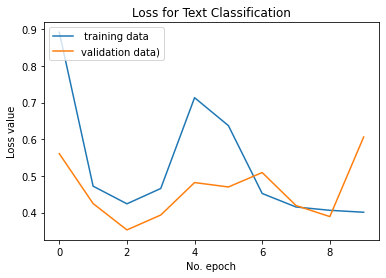

In [19]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

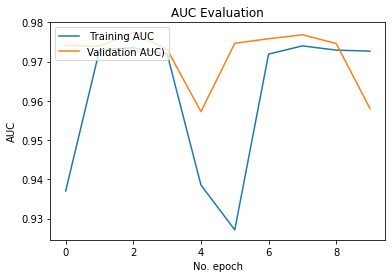

In [20]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [21]:
X_test

14477    elmablint braceletring rockstarjewels goldjewe...
12068                               you'll brosif! forrest
5640     health insurance probably change 2014 aca exch...
11444    power outages canberra forrest ainslie expecte...
11748    oh my. thebutler filmthatmatters important sto...
                               ...                        
8761     continued devaluation jamaican dollar threaten...
8210     slave bankers! dollar economy cyprus fed ecb i...
19170    1.09 carat 100% natural d vs2 round loose diam...
14745    : gold chain. goldjewelry plndr. shop use repc...
18921    1.4 ct emerald. band diamond diamonds emerald ...
Name: tweet, Length: 2226, dtype: object

In [22]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-22-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [23]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
70/70 [==============================] - 5s 68ms/step


array([1, 1, 1, ..., 2, 1, 2])

In [24]:
y_test.shape
y_test

14477     Neutral
12068     Neutral
5640      Neutral
11444    Negative
11748    Positive
           ...   
8761      Neutral
8210      Neutral
19170    Negative
14745     Neutral
18921    Positive
Name: Analysis, Length: 2226, dtype: object

In [25]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

In [26]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       0.63      1.00      0.77       608
    Negative       0.00      0.00      0.00       257
     Neutral       1.00      0.92      0.96      1361

    accuracy                           0.84      2226
   macro avg       0.54      0.64      0.58      2226
weighted avg       0.78      0.84      0.80      2226



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
